In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split

import unicodedata
import re
import numpy as np
import os
import io
import time

In [2]:
# Download the file
path_to_zip = tf.keras.utils.get_file(
    'spa-eng.zip', origin='http://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip',
    extract=True)

path_to_file = os.path.dirname(path_to_zip)+"/spa-eng/spa.txt"
print("Download to..:",path_to_file)

2646016/2638744 [==============================] - 4s 1us/step


In [5]:
#### Converts the unicode file to ascii
def unicode_to_ascii(s):
    #正規化；Normalization Form Decompose
    #汎用カテゴリ：http://www.unicode.org/reports/tr44/#General_Category_Values
    #Mn: 	Nonspacing_Mark	a nonspacing combining mark (zero advance width)
    return ''.join(c for c in unicodedata.normalize('NFD', s)
                   if unicodedata.category(c) != 'Mn')

####  sentence preprocesser
def preprocess_sentence(w):
    w = unicode_to_ascii(w.lower().strip())

    # creating a space between a word and the punctuation following it
    # eg: "he is a boy." => "he is a boy ."
    # Reference:- https://stackoverflow.com/questions/3645931/python-padding-punctuation-with-white-spaces-keeping-punctuation
    w = re.sub(r"([?.!,¿])", r" \1 ", w)
    w = re.sub(r'[" "]+', " ", w)

    # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",")
    w = re.sub(r"[^a-zA-Z?.!,¿]+", " ", w)

    w = w.rstrip().strip()

    # adding a start and an end token to the sentence
    # モデルが予測をいつ開始し、いつ終了すれば良いかを知らせるため
    w = '<start> ' + w + ' <end>'
    return w

In [6]:
en_sentence = u"May I borrow this book?"
sp_sentence = u"¿Puedo tomar prestado este libro?"
print(preprocess_sentence(en_sentence))
print(preprocess_sentence(sp_sentence).encode('utf-8'))

<start> may i borrow this book ? <end>
b'<start> \xc2\xbf puedo tomar prestado este libro ? <end>'


In [7]:
## 指定データセットからnum_examples文だけ(enflish , spanish)作る
# ある程度分かち書きや正規化などはする。
# 1. Remove the accents
# 2. Clean the sentences
# 3. Return word pairs in the format: [ENGLISH, SPANISH]
def create_dataset(path, num_examples):
    lines = io.open(path, encoding='UTF-8').read().strip().split('\n')

    word_pairs = [[preprocess_sentence(w) for w in l.split('\t')]  for l in lines[:num_examples]]
    

    return zip(*word_pairs)

In [8]:
en, sp = create_dataset(path_to_file, None)
print(en[-1])
print(sp[-1])

<start> if you want to sound like a native speaker , you must be willing to practice saying the same sentence over and over in the same way that banjo players practice the same phrase over and over until they can play it correctly and at the desired tempo . <end>
<start> si quieres sonar como un hablante nativo , debes estar dispuesto a practicar diciendo la misma frase una y otra vez de la misma manera en que un musico de banjo practica el mismo fraseo una y otra vez hasta que lo puedan tocar correctamente y en el tiempo esperado . <end>


In [33]:
#ベクトル*文章数のテンソルのうち、最大次元数
def max_length(tensor):
    return max(len(t) for t in tensor)

- tf.keras.preprocessing.text.Tokenizer(
- テキストをトークン化するユーティリティクラス．
    - 各テキストを整数の列（各整数はは辞書におけるトークンのインデックス）または単語のカウントやtf-idfなどに基づいて各トークンをバイナリとした係数からなるベクトルに変換することで，テキストコーパスをベクトル化します．
- テキストをベクトル化する，または/かつ，テキストをシーケンス（= データセット中でランクi（1から始まる）の単語がインデックスiを持つ単語インデックスのリスト）に変換するクラス．
- args
    - num_words: 利用する単語の最大数で単語の頻度に基づきます．一般的にはnum_words-1が用いられます．
    - filters: テキストからフィルタする文字の要素からなる文字列．デフォルトでは全ての句読点に加えてタブや開業，マイナス，'文字です．
    - lower: 真理値．テキストを小文字にするかどうか．
    - split: 文字列．単語を分割するセパレータ．
    - char_level: Trueなら，全文字はトークンとして扱われます．
    - oov_token: 与えられた場合，単語のインデックスに付与され，text_to_sequenceが呼ばれた時に語彙にない単語を入れ替えるために使われます．

In [31]:
#### langに対して、ベクトル化
# そのままtensor
# 固定長lang_tokenizer

def tokenize(lang):
    # Tokenizerをインスタンス化
    lang_tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')
    # 文章を与える。
    lang_tokenizer.fit_on_texts(lang)
    
#     print("#doc : ", lang_tokenizer.document_count)
#     print("#words in doc : \n", lang_tokenizer.word_counts)
#     print("index of word :",lang_tokenizer.word_index)

    #単語のシーケンス番号（1～）の列を示すベクトルが得られる。
    tensor = lang_tokenizer.texts_to_sequences(lang)
#     print(tensor)

    #固定長に変換
    #最大長指定なし→最大の文字長に合わせる
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor,
                                                         padding='post')

    return tensor, lang_tokenizer

In [25]:
tokenize(sp[-1])

#doc :  280
#words in doc : 
 OrderedDict([('<', 2), ('s', 16), ('t', 15), ('a', 30), ('r', 16), ('>', 2), ('i', 13), ('q', 3), ('u', 10), ('e', 29), ('o', 17), ('n', 15), ('c', 10), ('m', 11), ('h', 2), ('b', 3), ('l', 6), ('v', 3), (',', 1), ('d', 9), ('p', 6), ('f', 2), ('y', 3), ('z', 2), ('j', 1), ('.', 1)])
[[19], [4], [6], [1], [5], [6], [20], [], [4], [8], [], [15], [10], [8], [2], [5], [2], [4], [], [4], [3], [7], [1], [5], [], [11], [3], [9], [3], [], [10], [7], [], [21], [1], [16], [13], [1], [7], [6], [2], [], [7], [1], [6], [8], [17], [3], [], [24], [], [12], [2], [16], [2], [4], [], [2], [4], [6], [1], [5], [], [12], [8], [4], [14], [10], [2], [4], [6], [3], [], [1], [], [14], [5], [1], [11], [6], [8], [11], [1], [5], [], [12], [8], [11], [8], [2], [7], [12], [3], [], [13], [1], [], [9], [8], [4], [9], [1], [], [22], [5], [1], [4], [2], [], [10], [7], [1], [], [18], [], [3], [6], [5], [1], [], [17], [2], [23], [], [12], [2], [], [13], [1], [], [9], [8], [4], [9], [1], [],

(array([[19],
        [ 4],
        [ 6],
        [ 1],
        [ 5],
        [ 6],
        [20],
        [ 0],
        [ 4],
        [ 8],
        [ 0],
        [15],
        [10],
        [ 8],
        [ 2],
        [ 5],
        [ 2],
        [ 4],
        [ 0],
        [ 4],
        [ 3],
        [ 7],
        [ 1],
        [ 5],
        [ 0],
        [11],
        [ 3],
        [ 9],
        [ 3],
        [ 0],
        [10],
        [ 7],
        [ 0],
        [21],
        [ 1],
        [16],
        [13],
        [ 1],
        [ 7],
        [ 6],
        [ 2],
        [ 0],
        [ 7],
        [ 1],
        [ 6],
        [ 8],
        [17],
        [ 3],
        [ 0],
        [24],
        [ 0],
        [12],
        [ 2],
        [16],
        [ 2],
        [ 4],
        [ 0],
        [ 2],
        [ 4],
        [ 6],
        [ 1],
        [ 5],
        [ 0],
        [12],
        [ 8],
        [ 4],
        [14],
        [10],
        [ 2],
        [ 4],
        [ 6],
      

In [28]:
def load_dataset(path, num_examples=None):
    # creating data
    # get input and clean it , output pair
    targ_lang, inp_lang = create_dataset(path, num_examples)

    #to tensor 
    input_tensor, inp_lang_tokenizer = tokenize(inp_lang)
    target_tensor, targ_lang_tokenizer = tokenize(targ_lang)

    return input_tensor, target_tensor, inp_lang_tokenizer, targ_lang_tokenizer

In [32]:
# Try experimenting with the size of that dataset
num_examples = 30000
input_tensor, target_tensor, inp_lang, targ_lang = load_dataset(path_to_file, num_examples)

# Calculate max_length of the target tensors
max_length_targ, max_length_inp = max_length(target_tensor), max_length(input_tensor)

# Creating training and validation sets using an 80-20 split
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(input_tensor, target_tensor, test_size=0.2)

# Show length
print(len(input_tensor_train), len(target_tensor_train), len(input_tensor_val), len(target_tensor_val))

24000 24000 6000 6000


In [34]:
def convert(lang, tensor):
    for t in tensor:
        if t!=0:
            print ("%d ----> %s" % (t, lang.index_word[t]))

In [36]:
##　ちゃんと対応取れているよ！
print ("Input Language; index to word mapping")
convert(inp_lang, input_tensor_train[0])
print ()
print ("Target Language; index to word mapping")
convert(targ_lang, target_tensor_train[0])

Input Language; index to word mapping
1 ----> <start>
6575 ----> inspira
1409 ----> profundamente
3 ----> .
2 ----> <end>

Target Language; index to word mapping
1 ----> <start>
1060 ----> breathe
33 ----> in
2201 ----> deeply
3 ----> .
2 ----> <end>


## Create a tf.data dataset

In [38]:
BUFFER_SIZE = len(input_tensor_train)
BATCH_SIZE = 64
steps_per_epoch = len(input_tensor_train)//BATCH_SIZE
#埋め込み次元
embedding_dim = 256
#Encoderのユニット数(隠れ層のユニット数)
units = 1024

#入力の辞書サイズ
vocab_inp_size = len(inp_lang.word_index)+1
#ターゲットの辞書サイズ
vocab_tar_size = len(targ_lang.word_index)+1

#文字列の配列をスライスすると、文字列のデータセットが出来上がります。
#シャッフルで
dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train)).shuffle(BUFFER_SIZE)
#バッチサイズに区切る
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

In [39]:
example_input_batch, example_target_batch = next(iter(dataset))
example_input_batch.shape, example_target_batch.shape

(TensorShape([64, 16]), TensorShape([64, 11]))

### Encoderの設置

In [40]:
#エンコーダーは入力文字が各ユニットにどの程度重みをつけるかを計算する。
class Encoder(tf.keras.Model):
    #vocab_size: 辞書サイズ,
    #embedding_dim: 隠れ層サイズ
    #enc_units: encodeのユニット数
    #batch_sz: バッチサイズ
    def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
        super(Encoder, self).__init__()
        self.batch_sz = batch_sz
        self.enc_units = enc_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        ## GRU:RNN以上LSTM以下のもの
        ## Gated Recurrent Unit
        # Glorot の正規分布（Xavier の正規分布とも呼ばれます）による初期化を実施
        # https://keras.io/ja/initializers/
        self.gru = tf.keras.layers.GRU(self.enc_units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')
    #フォーワード計算を行う。
    def call(self, x, hidden):
        x = self.embedding(x)
        output, state = self.gru(x, initial_state = hidden)
        return output, state
    
    # 残りの初期化を行う 
    def initialize_hidden_state(self):
        return tf.zeros((self.batch_sz, self.enc_units))

In [41]:
encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)

# サンプル入力
sample_hidden = encoder.initialize_hidden_state()
# 試しに１バッチだけ入れてみる
# Call呼び出し
sample_output, sample_hidden = encoder(example_input_batch, sample_hidden)

print ('Encoder output shape: (batch size, sequence length, hidden units) {}'.format(sample_output.shape))
print ('Encoder Hidden state shape: (batch size, hidden units) {}'.format(sample_hidden.shape))

Encoder output shape: (batch size, sequence length, units) (64, 16, 1024)
Encoder Hidden state shape: (batch size, units) (64, 1024)


### Attensionの設置 

In [42]:
class BahdanauAttention(tf.keras.layers.Layer):
    #units:コンテキストベクターとしてデコーダに渡すので、decodeerのunit数
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)
    
    def call(self, query, values):
        # hidden shape == (batch_size, hidden size)
        # hidden_with_time_axis shape == (batch_size, 1, hidden size)
        # スコアを計算するためにこのように加算を実行する
        #tf.expand_dims　添字"axis"でのサイズ1の次元を加える
        hidden_with_time_axis = tf.expand_dims(query, 1)

        # score shape == (batch_size, max_length, 1)
        # スコアを self.V に適用するために最後の軸は 1 となる        
        # self.V に適用する前のテンソルの shape は  (batch_size, max_length, units)
        # Denceは和を計算(1次元)
        # ==> Scoreは関連度；　推測したい言葉(target)から計算された出力(query：hidden_with_time_axis)を全てのencoder出力(values)から計算される。
        # transformerなら内積取るらしい
        score = self.V(
            tf.nn.tanh(
                self.W1(values) + self.W2(hidden_with_time_axis)
            )
        )

        # attention_weights の shape == (batch_size, max_length, 1)
        # 各max_length分のユニットに対し、attention_weightsが作成される(batch_size分)
        attention_weights = tf.nn.softmax(score, axis=1)

        # context_vector の合計後の shape == (batch_size, hidden_size)
        # 関連度でencoderに重みつける(values:全てのencoder出力)
        context_vector = attention_weights * values
        
        #　axis+1次元目で総和を取る
        # 全てのencoder出力と推測したい言葉(target)から計算された出力(状態)を鑑みた結果が出てくる
        #　つまり ｑuery と　valueで毎回全結合層のアップデートが掛かる＝＞データのどこにattentionを向けるのかが変化
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights

In [43]:
#サンプル
attention_layer = BahdanauAttention(10)
#encodeerのテストで作成済み
# sample_hidden:隠れ層の状態
# sample_output:sample_inputをsample_hiddenの状態でencoderに突っ込んだ場合の出力
attention_result, attention_weights = attention_layer(sample_hidden, sample_output)

print("Attention result shape: (batch size, units) {}".format(attention_result.shape))
print("Attention weights shape: (batch_size, sequence_length, 1) {}".format(attention_weights.shape))

Attention result shape: (batch size, units) (64, 1024)
Attention weights shape: (batch_size, sequence_length, 1) (64, 16, 1)


### decoderの設置

In [44]:

class Decoder(tf.keras.Model):
    
    #vocab_size: 辞書サイズ(出力側はまた違うサイズ)
    #embedding_dim: 隠れ層サイズ
    #dec_units: decodeのユニット数
    #batch_sz: バッチサイズ
    
    def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
        super(Decoder, self).__init__()
        self.batch_sz = batch_sz
        self.dec_units = dec_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(self.dec_units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')
        self.fc = tf.keras.layers.Dense(vocab_size)

        # アテンションのため
        self.attention = BahdanauAttention(self.dec_units)

    def call(self, x, hidden, enc_output):
        #　まず、decoderの隠れとencorderのアウトプットからアテンション計算
        # context_vector, attention_weightsを得る
        # enc_output の shape == (batch_size, max_length, hidden_size)
        context_vector, attention_weights = self.attention(hidden, enc_output)

        # 埋め込み層を通過したあとの x の shape  == (batch_size, 1, embedding_dim)
        x = self.embedding(x)

        # 結合後の x の shape == (batch_size, 1, embedding_dim + hidden_size)
        # GRUへは直列で渡す
        # tf.concat : Negative axis are interpreted as counting from the end of the rank, i.e., axis + rank(values)-th dimension.
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

        # 結合したベクトルを GRU 層に渡す
        output, state = self.gru(x)

        # output shape == (batch_size * 1, hidden_size)
        output = tf.reshape(output, (-1, output.shape[2]))

        # output shape == (batch_size, vocab)
        x = self.fc(output)

        return x, state, attention_weights

In [55]:

decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)

sample_decoder_output, _, _ = decoder(tf.random.uniform((64, 1)),
                                      sample_hidden, sample_output)

print ('Decoder output shape: (batch_size, vocab size) {}'.format(sample_decoder_output.shape))

Decoder output shape: (batch_size, vocab size) (64, 4935)


### オプティマイザと損失関数の定義

In [56]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)
    
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

### チェックポイント（オブジェクトベースの保存

In [48]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

### 訓練
- 
- エンコーダーの出力とエンコーダーの隠れ状態、そしてデコーダーの入力（これが 開始トークン）がデコーダーに渡される
- デコーダーは 予測値 と デコーダーの隠れ状態 を返す
- つぎにデコーダーの隠れ状態がモデルに戻され、予測値が損失関数の計算に使用される
- デコーダーへの次の入力を決定するために Teacher Forcing が使用される
- Teacher Forcing は、正解単語 をデコーダーの 次の入力 として使用するテクニックである
- 最後に勾配を計算し、それをオプティマイザに与えて誤差逆伝播を行う

In [57]:
@tf.function
def train_step(inp, targ, enc_hidden):
    # デコレータはtf.sessionのようなもの
    loss = 0

    #GradientTape とは勾配を求めるためのクラス
    #内部でtapeで記録された変数は自動的に
    with tf.GradientTape() as tape:
        
        #入力をエンコーダーに通すと、エンコーダー出力とエンコーダーの隠れ状態 が返される
        enc_output, enc_hidden = encoder(inp, enc_hidden)

        #状態の共有
        dec_hidden = enc_hidden

        dec_input = tf.expand_dims([targ_lang.word_index['<start>']] * BATCH_SIZE, 1)

        # Teacher Forcing - 正解値を次の入力として供給
        for t in range(1, targ.shape[1]):
            # passing enc_output to the decoder
            predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)
            loss += loss_function(targ[:, t], predictions)

            # Teacher Forcing を使用
            dec_input = tf.expand_dims(targ[:, t], 1)

    batch_loss = (loss / int(targ.shape[1]))

    #tf.keras.Model.trainable_variablesを呼び出すことで、そのネットワークに含まれる重みをリストとして得られる
    variables = encoder.trainable_variables + decoder.trainable_variables

    #得られた変数について、微分→更新
    gradients = tape.gradient(loss, variables)
    optimizer.apply_gradients(zip(gradients, variables))

    return batch_loss

In [54]:
EPOCHS = 10

for epoch in range(EPOCHS):
    start = time.time()

    enc_hidden = encoder.initialize_hidden_state()
    total_loss = 0

    for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
        batch_loss = train_step(inp, targ, enc_hidden)
        total_loss += batch_loss

        if batch % 100 == 0:
            print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,batch,batch_loss.numpy()))
            
    # 2 エポックごとにモデル（のチェックポイント）を保存
    if (epoch + 1) % 2 == 0:
        checkpoint.save(file_prefix = checkpoint_prefix)

    print('Epoch {} Loss {:.4f}'.format(epoch + 1,
                                      total_loss / steps_per_epoch))
    print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 4.6384
Epoch 1 Batch 100 Loss 2.2382
Epoch 1 Batch 200 Loss 1.8553
Epoch 1 Batch 300 Loss 1.6820
Epoch 1 Loss 2.0010
Time taken for 1 epoch 652.7817220687866 sec

Epoch 2 Batch 0 Loss 1.6052
Epoch 2 Batch 100 Loss 1.4589
Epoch 2 Batch 200 Loss 1.3249
Epoch 2 Batch 300 Loss 1.2689
Epoch 2 Loss 1.3451
Time taken for 1 epoch 695.7474308013916 sec

Epoch 3 Batch 0 Loss 1.0709
Epoch 3 Batch 100 Loss 0.9688
Epoch 3 Batch 200 Loss 0.8728
Epoch 3 Batch 300 Loss 0.9290
Epoch 3 Loss 0.9185
Time taken for 1 epoch 687.9900529384613 sec

Epoch 4 Batch 0 Loss 0.5766
Epoch 4 Batch 100 Loss 0.6308
Epoch 4 Batch 200 Loss 0.6592
Epoch 4 Batch 300 Loss 0.6458
Epoch 4 Loss 0.6059
Time taken for 1 epoch 629.6567442417145 sec

Epoch 5 Batch 0 Loss 0.3796
Epoch 5 Batch 100 Loss 0.3520
Epoch 5 Batch 200 Loss 0.3838
Epoch 5 Batch 300 Loss 0.4244
Epoch 5 Loss 0.4039
Time taken for 1 epoch 656.3540561199188 sec

Epoch 6 Batch 0 Loss 0.2757
Epoch 6 Batch 100 Loss 0.3140
Epoch 6 Batch 200 Loss

In [63]:
def evaluate(sentence):
    attention_plot = np.zeros((max_length_targ, max_length_inp))

    sentence = preprocess_sentence(sentence)

    inputs = [inp_lang.word_index[i] for i in sentence.split(' ')]
    inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
                                                           maxlen=max_length_inp,
                                                           padding='post')
    inputs = tf.convert_to_tensor(inputs)

    result = ''

    hidden = [tf.zeros((1, units))]
    enc_out, enc_hidden = encoder(inputs, hidden)

    dec_hidden = enc_hidden
    dec_input = tf.expand_dims([targ_lang.word_index['<start>']], 0)

    for t in range(max_length_targ):
        predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                             dec_hidden,
                                                             enc_out)

        # 後ほどプロットするためにアテンションの重みを保存
        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention_plot[t] = attention_weights.numpy()

        predicted_id = tf.argmax(predictions[0]).numpy()

        result += targ_lang.index_word[predicted_id] + ' '

        if targ_lang.index_word[predicted_id] == '<end>':
            return result, sentence, attention_plot

        # 予測された ID がモデルに戻される
        dec_input = tf.expand_dims([predicted_id], 0)

    return result, sentence, attention_plot

In [64]:
# アテンションの重みをプロットする関数
def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')

    fontdict = {'fontsize': 14}

    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()

In [65]:
def translate(sentence):
    result, sentence, attention_plot = evaluate(sentence)

    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))

    attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
    plot_attention(attention_plot, sentence.split(' '), result.split(' '))

In [66]:
# checkpoint_dir の中の最後のチェックポイントを復元
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))


Input: <start> hace mucho frio aqui . <end>
Predicted translation: voted voted voted voted voted voted voted voted voted voted voted 


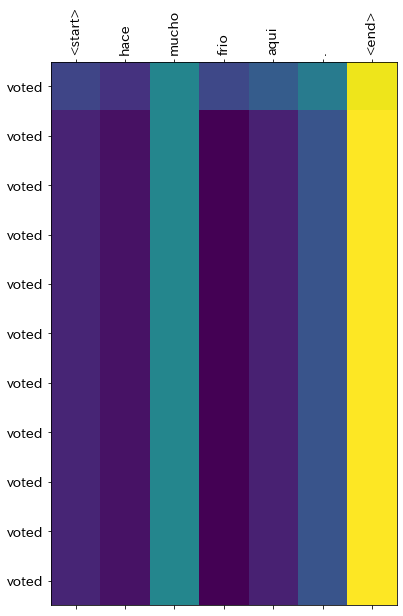

In [68]:
translate(u'hace mucho frio aqui.')